## Config and importing

In [1]:
import sys
import datetime

import tensorflow as tf
from keras import layers
from keras.models import Sequential
from keras import backend as K

%pylab inline
%env CUDA_VISIBLE_DEVICES=1,2,3,4

sess = tf.InteractiveSession(config = tf.ConfigProto(gpu_options = tf.GPUOptions(allow_growth = True)))

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib
env: CUDA_VISIBLE_DEVICES=1,2,3,4


## Import data

In [34]:
f = open('data/electrons_log', 'rb')
data = load(f, encoding='latin1')

tanh_data = np.tanh(data)

## Build generator

In [3]:
class CaloGAN():
    def __init__():
        pass
    
    def fit():
        pass
    
    def predict():
        pass

In [4]:
noise_shape = 100
img_shape = (30, 30, 1)
dropout = 0.3
leak_slope = 0.2
K.set_learning_phase(1)

def build_generator_model(noise_shape):
    generator = Sequential()
    
    generator.add(layers.InputLayer(input_shape=[noise_shape]))
    generator.add(layers.Dense(7 * 7))
    generator.add(layers.BatchNormalization())
    generator.add(layers.Activation('relu'))
    generator.add(layers.Reshape((7, 7, 1)))
    generator.add(layers.Deconv2D(128, kernel_size=(5, 5)))
    generator.add(layers.BatchNormalization())
    generator.add(layers.Activation('relu'))
    generator.add(layers.Deconv2D(128, kernel_size=(5, 5)))
    generator.add(layers.BatchNormalization())
    generator.add(layers.Activation('relu'))
    generator.add(layers.Deconv2D(64, kernel_size=(5, 5)))
    generator.add(layers.BatchNormalization())
    generator.add(layers.Activation('relu'))
    generator.add(layers.Deconv2D(64, kernel_size=(5, 5)))
    generator.add(layers.BatchNormalization())
    generator.add(layers.Activation('relu'))
    generator.add(layers.Deconv2D(32, kernel_size=(4, 4)))
    generator.add(layers.BatchNormalization())
    generator.add(layers.Activation('relu'))
    generator.add(layers.Deconv2D(32, kernel_size=(4, 4)))
    generator.add(layers.BatchNormalization())
    generator.add(layers.Activation('relu'))
    generator.add(layers.Deconv2D(16, kernel_size=(4, 4)))
    generator.add(layers.BatchNormalization())
    generator.add(layers.Activation('relu'))
    generator.add(layers.Conv2D(1, kernel_size=(3, 3), activation='tanh'))
    
#     generator.summary()
    return generator

def build_discriminator_model(img_shape):
    discriminator = Sequential()
    
    discriminator.add(layers.InputLayer(img_shape))
    discriminator.add(layers.Conv2D(32, kernel_size=(3, 3), strides=2))
    discriminator.add(layers.LeakyReLU(leak_slope))
    discriminator.add(layers.Conv2D(32, kernel_size=(3, 3)))
    discriminator.add(layers.BatchNormalization())
    discriminator.add(layers.LeakyReLU(leak_slope))
    discriminator.add(layers.Conv2D(64, kernel_size=(3, 3)))
    discriminator.add(layers.BatchNormalization())
    discriminator.add(layers.LeakyReLU(leak_slope))
    discriminator.add(layers.Conv2D(64, kernel_size=(3, 3), strides=2))
    discriminator.add(layers.BatchNormalization())
    discriminator.add(layers.LeakyReLU(leak_slope))
    discriminator.add(layers.Conv2D(128, kernel_size=(3, 3)))
    discriminator.add(layers.BatchNormalization())
    discriminator.add(layers.LeakyReLU(leak_slope))
    discriminator.add(layers.Flatten())
    discriminator.add(layers.Dense(256))
    discriminator.add(layers.BatchNormalization())
    discriminator.add(layers.Activation('tanh'))
    discriminator.add(layers.Dense(2, activation=tf.nn.log_softmax))
        
#     discriminator.summary()
    return discriminator

gen = build_generator_model(noise_shape)
dis = build_discriminator_model(img_shape)

In [5]:
beta_1 = 0.5
learning_rate = 0.0002

noise = tf.placeholder(tf.float32, [None, noise_shape])
real_data = tf.placeholder(tf.float32, [None,] + list(img_shape))

discriminated_real_data = dis(real_data)

generated_data = gen(noise)
discriminated_generated_data = dis(generated_data)

########################
#discriminator training#
########################
discriminator_loss = -tf.reduce_mean(discriminated_generated_data[:, 0] + discriminated_real_data[:, 1])
discriminator_loss += tf.reduce_mean(dis.layers[-1].kernel ** 2)

discriminator_optimize = tf.train.GradientDescentOptimizer(learning_rate=0.001) \
                                .minimize(discriminator_loss, var_list=dis.trainable_weights)

########################
###generator training###
########################
generator_loss = -tf.reduce_mean(discriminated_generated_data[:, 1])

generator_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta_1) \
                                .minimize(generator_loss, var_list = gen.trainable_weights)

sess.run(tf.global_variables_initializer())

In [13]:
gen.load_weights('upgrade_gen_model-Copy1.h5')
dis.load_weights('upgrade_dis_model-Copy1.h5')

In [8]:
from matplotlib import patches

NOISE_SHAPE = 100
IMG_SHAPE = (30, 30, 1)

global_data = tanh_data


def sample_noise_batch(bsize):
    return np.random.normal(loc=0, scale=0.02, size=(bsize, NOISE_SHAPE)).astype('float32')

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(global_data.shape[0]), size=bsize)
    return global_data[idxs].reshape((-1, 30, 30, 1))

def sample_images(nrow, ncol, figsize=(17, 8)):
    images = gen.predict(sample_noise_batch(bsize= nrow * ncol ))
    if np.var(images)!= 0:
        images = images.clip(np.min(global_data), np.max(global_data))
    
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize)
    
            
    if nrow == 1 or ncol == 1:
        for i, i_axes, in enumerate(axes):
            rect_1 = patches.Rectangle((14, 14), 2, 2, linewidth=1,edgecolor='b',facecolor='none')
            rect_2 = patches.Rectangle((13, 13), 4, 4, linewidth=1,edgecolor='y',facecolor='none')
            rect_3 = patches.Rectangle((12, 12), 6, 6, linewidth=1,edgecolor='r',facecolor='none')
            
            i_axes.imshow(np.exp(images[i]).reshape(30, 30), cmap="gray", interpolation="none")
            i_axes.add_patch(rect_1)
            i_axes.add_patch(rect_2)
            i_axes.add_patch(rect_3)
    else:
        for i in range(nrow * ncol):
            rect_1 = patches.Rectangle((14, 14), 2, 2, linewidth=1,edgecolor='b',facecolor='none')
            rect_2 = patches.Rectangle((13, 13), 4, 4, linewidth=1,edgecolor='y',facecolor='none')
            rect_3 = patches.Rectangle((12, 12), 6, 6, linewidth=1,edgecolor='r',facecolor='none')
    
            axes[i // ncol , i % ncol].imshow(np.exp(images[i]).reshape(30, 30), cmap="gray", interpolation="none")
            axes[i // ncol , i % ncol].add_patch(rect_1)
            axes[i // ncol , i % ncol].add_patch(rect_2)
            axes[i // ncol , i % ncol].add_patch(rect_3)
            
    plt.show()

def sample_probas(bsize, figsize=(17, 8)):
    plt.figure(figsize=figsize)
    plt.title('Generated vs real data')
    plt.hist(np.exp(dis.predict(sample_data_batch(bsize)))[:,1],
             label='D(x)', alpha=0.5,range=[0,1])
    plt.hist(np.exp(dis.predict(gen.predict(sample_noise_batch(bsize))))[:,1],
             label='D(G(z))',alpha=0.5,range=[0,1])
    plt.legend(loc='best')
    plt.show()

def sample_data(batch_size):
    return gen.predict(sample_noise_batch(batch_size)).reshape(-1, 30, 30)

def save_models():
    now = datetime.datetime.now().isoformat().split('T')[0]
    gen.save("upgrade_gen_model+{}.h5".format(now))
    dis.save("upgrade_dis_model+{}.h5".format(now))

def joint_distribution(sample_data, real_data, figsize=(17, 8)):
    plt.figure(figsize=figsize)
    plt.hist(real_data.sum(axis=(1, 2)), label='real', bins=100, alpha=0.3)
    plt.hist(sample_data.sum(axis=(1, 2)), label='gen', bins=100, alpha=0.3)
    plt.title('all data')
    plt.legend()
#     plt.savefig('all_data.jpeg')
    plt.show()
    
def full_vis(figsize):
    sample_images(1, 2, figsize)
    sample_probas(1000, figsize)
    
    sample_imgs = sample_data(4000)
    joint_distribution(sample_imgs, global_data[:4000], figsize)
    

epoch 700


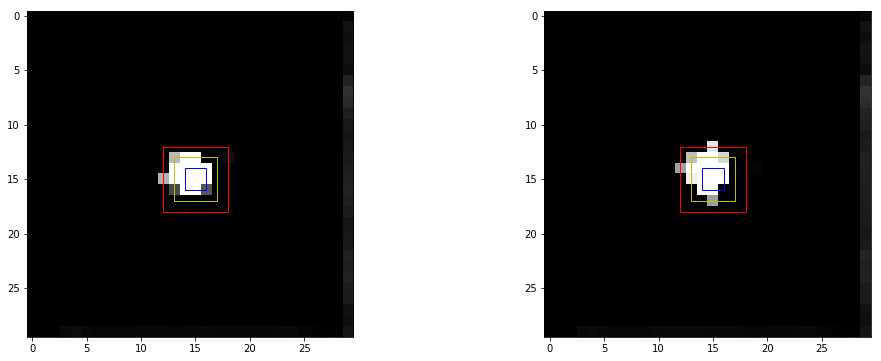

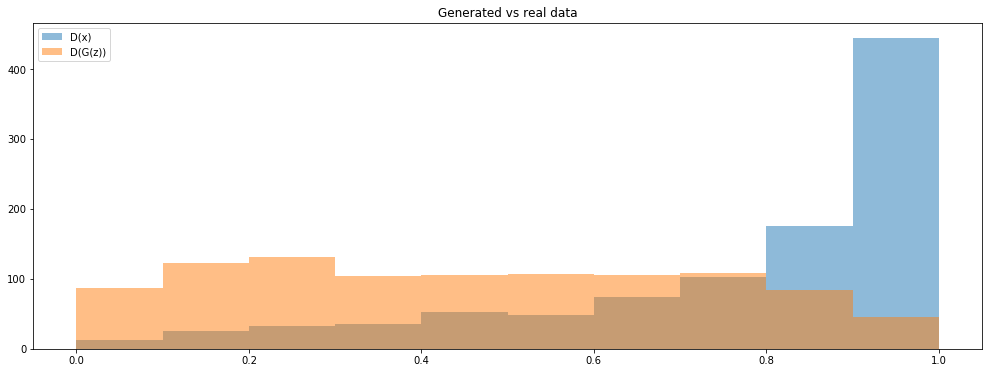

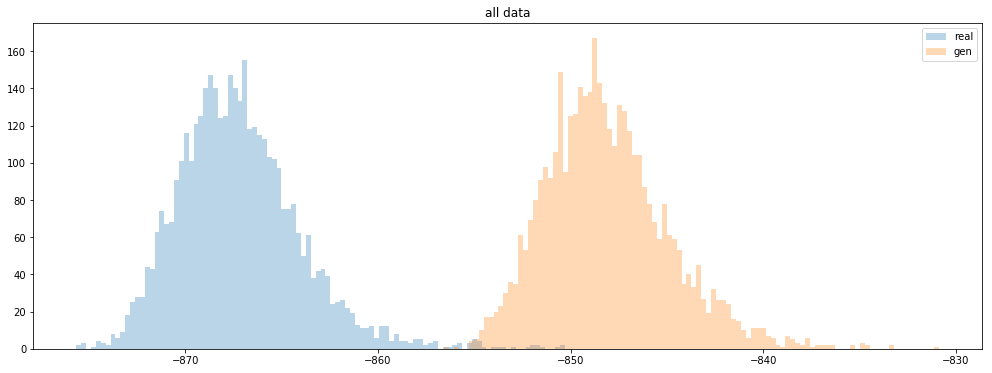

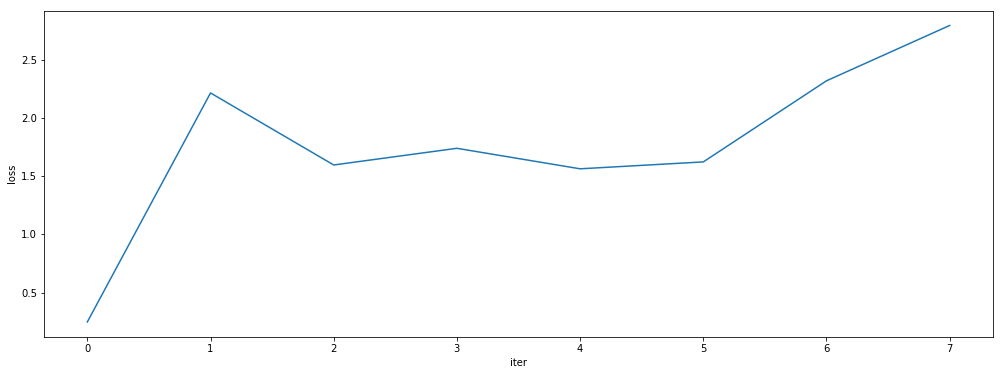

KeyboardInterrupt: 

In [61]:
from IPython import display
from tqdm import tnrange

loss_list = []
prev_img = gen.predict(sample_noise_batch(1))[0, :, :, 0]
for epoch in tnrange(50000):
    
    feed_dict = {
        real_data : sample_data_batch(100),
        noise : sample_noise_batch(100)
    }
    
    for i in range(5):
        sess.run(discriminator_optimize, feed_dict)
    
    sess.run(generator_optimizer, feed_dict)
    
    if epoch % 100 == 0:
        save_models()
        
        display.clear_output()
        print("epoch", epoch)
        
        full_vis((17, 6))
        
        new_img = gen.predict(sample_noise_batch(1))[0, :, :, 0]
        diff = np.linalg.norm(prev_img - new_img)
        prev_img = new_img
        loss_list.append(diff)
        
        plt.figure(figsize=(17, 6))
        plt.xlabel('iter')
        plt.ylabel('loss')
        plt.plot(loss_list)
        plt.show()

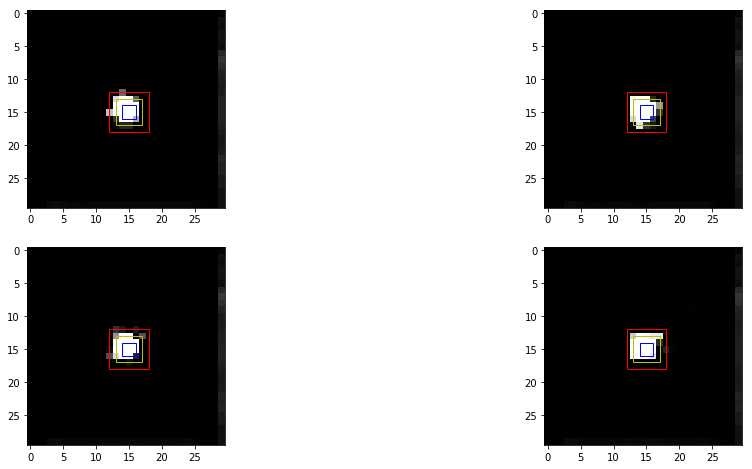

In [64]:
sample_images(2, 2)

In [65]:
sample_imgs = sample_data(10000)

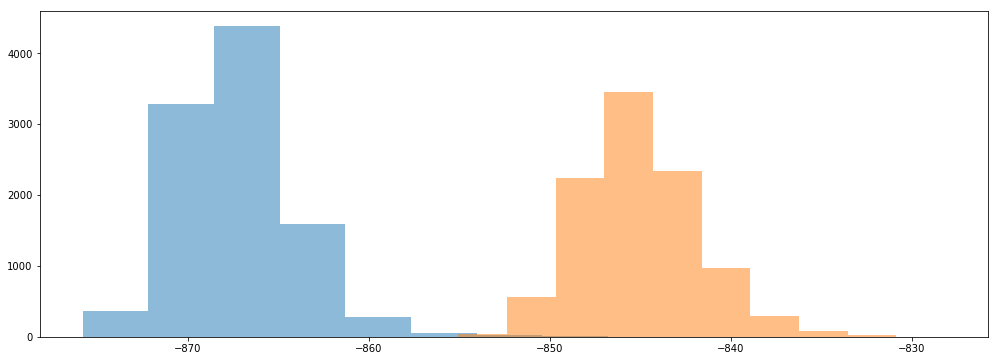

In [66]:
plt.figure(figsize=(17, 6))
plt.hist(tanh_data.sum(axis=(1, 2)), label='real', alpha=0.5)
plt.hist(sample_imgs.sum(axis=(1, 2)), label='generated', alpha=.5)
plt.show()

In [57]:
def second_moments(sample_imgs):
    def common_energy(img):
        return img.sum()
    
    def xx(img):
#         print(img)
        flatten_img = img.flatten()
        s_xx = 0
        center_index = img.shape[0] // 2
        for energy_index in range(img.size):
#             print("Current diff :{}".format((energy_index % img.shape[0]) - center_index))
            s_xx += flatten_img[energy_index] * \
                      np.power((energy_index % img.shape[0]) - center_index, 2)
#         print(s_xx, common_energy(img))
        return s_xx / common_energy(img)
    
    def yy(img):
        return xx(img.T)
    
    def xy(img):
        flatten_img = img.flatten()
        center_index = img.shape[0] // 2
        img_shape = img.shape[0]
        s_xy = 0
        for energy_index in range(img.size):
            s_xy += flatten_img[energy_index] * ((energy_index % img_shape) - center_index) \
                        * ((energy_index // img_shape) - center_index)
        return s_xy / common_energy(img)
    
    xx_list, yy_list, xy_list = [], [], []
    for img in sample_imgs:
        xx_list.append(xx(img))
        yy_list.append(yy(img))
        xy_list.append(xy(img))
    
    return np.array((xx_list, yy_list, xy_list))
        
#     print(sample_imgs.shape)
sec_moment = second_moments(sample_imgs[:5000])

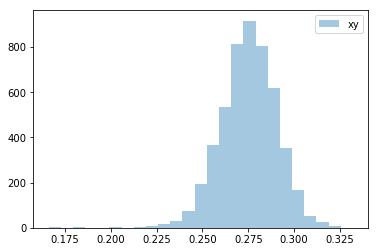

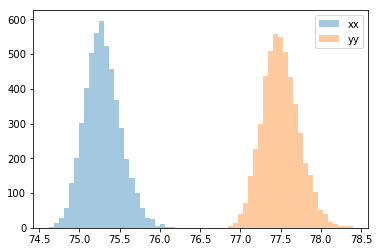

In [60]:
plt.hist(sec_moment[2], bins=25, label='xy', alpha=0.4)
plt.legend()
plt.savefig('xy.jpeg')
plt.show()

plt.hist(sec_moment[0], bins=25, label='xx', alpha=0.4)
plt.hist(sec_moment[1], bins=25,label='yy', alpha=0.4)
plt.legend()
plt.savefig('xx, yy.jpeg')
plt.show()

In [67]:
def foo(sample_data, real_data, x, y):
    s_1 = sample_data[:, x:(y + 1), x]
    s_2 = sample_data[:, x:(y + 1), y]
    s_3 = sample_data[:, x, (x + 1):y]
    s_4 = sample_data[:, y, (x + 1):y]
    
    s = np.hstack((s_1, s_2, s_3, s_4))
    
    r_1 = real_data[:, x:(y + 1), x]
    r_2 = real_data[:, x:(y + 1), y]
    r_3 = real_data[:, x, (x + 1):y]
    r_4 = real_data[:, y, (x + 1):y]
    
    r = np.hstack((r_1, r_2, r_3, r_4))
    
    return s, r

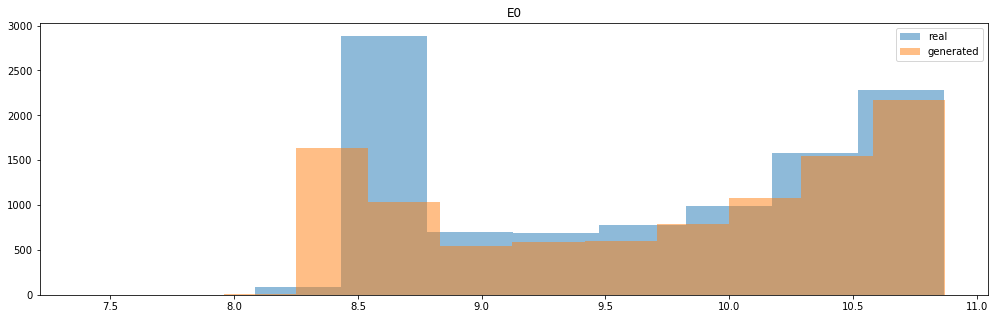

In [71]:
s, r = foo(sample_imgs, tanh_data, 15, 16)
s, r = np.exp(s), np.exp(r)

plt.figure(figsize=(17, 5))
plt.hist(r.sum(axis=1), label='real', alpha=0.5)
plt.hist(s.sum(axis=1), label='generated', alpha=.5)
plt.title("E0")
plt.legend()
plt.savefig('E0.jpeg')ц
plt.show()

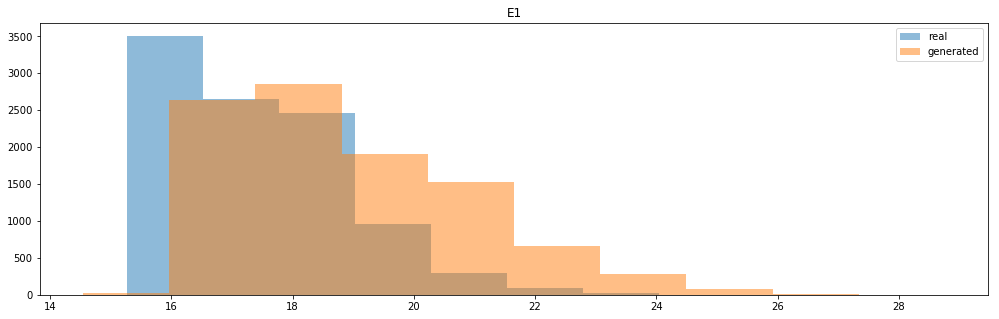

In [72]:
s, r = foo(sample_imgs, tanh_data, 14, 17)
s, r = np.exp(s), np.exp(r)

plt.figure(figsize=(17, 5))
plt.hist(r.sum(axis=1), alpha=0.5, label="real")
plt.hist(s.sum(axis=1), alpha=0.5, label="generated")
plt.title("E1")
plt.legend()
plt.savefig('E1.jpeg')
plt.show()

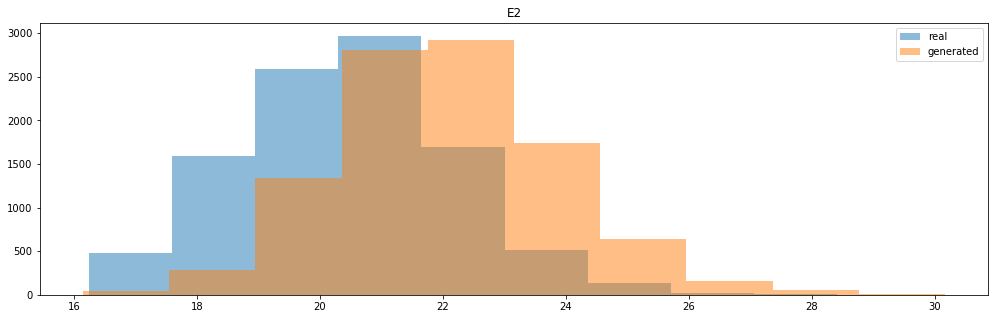

In [73]:
s, r = foo(sample_imgs, tanh_data, 13, 18)
s, r = np.exp(s), np.exp(r)

plt.figure(figsize=(17, 5))
plt.hist(r.sum(axis=1), alpha=0.5, label="real")
plt.hist(s.sum(axis=1), alpha=0.5, label="generated")
plt.title("E2")
plt.legend()
plt.savefig('E2.jpeg')
plt.show()

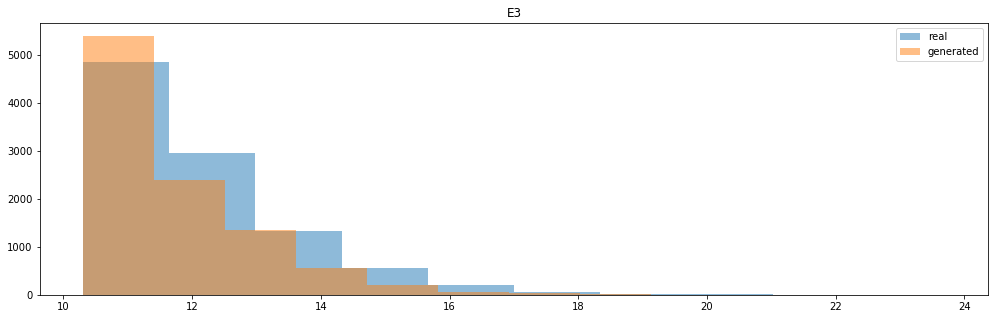

In [74]:
s, r = foo(sample_imgs, tanh_data, 12, 19)
s, r = np.exp(s), np.exp(r)

plt.figure(figsize=(17, 5))
plt.hist(r.sum(axis=1), alpha=0.5, label="real")
plt.hist(s.sum(axis=1), alpha=0.5, label="generated")
plt.title("E3")
plt.legend()
plt.savefig('E3.jpeg')
plt.show()

In [15]:
arc_sample_imgs = np.arctanh(sample_imgs)

# plt.imshow(arc_sample_imgs)

/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in arctanh
  """Entry point for launching an IPython kernel.


10.295762853650725

In [16]:
arc_sample_imgs.shape

(10000, 30, 30)

In [19]:
f = open('data/electrons_log', 'rb')
data = load(f, encoding='latin1')
data[np.isneginf(data)] = 0

arc_sample_imgs[np.isneginf(arc_sample_imgs)] = 0
arc_sample_imgs[np.isinf(arc_sample_imgs)] = 10


# plt.figure(figsize=(17, 6))
# plt.hist(sample_imgs.flatten(), alpha=0.5)
# plt.hist(data.flatten(), alpha=0.5)
# plt.show()

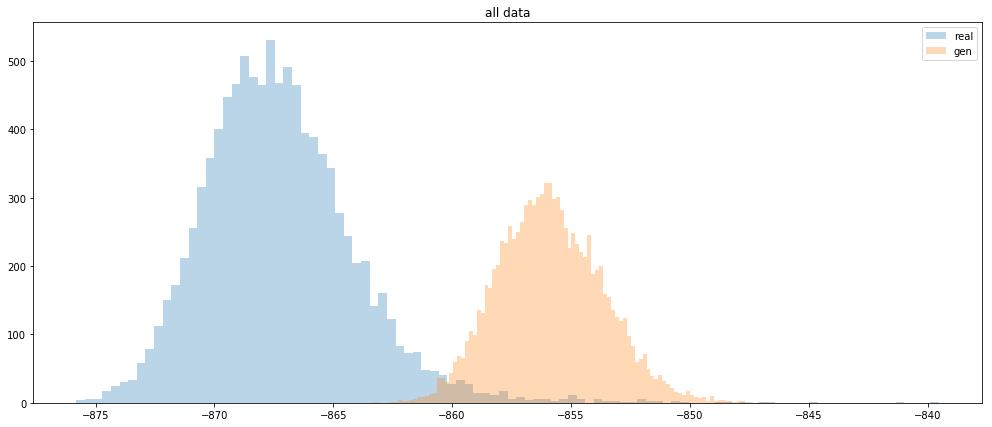

In [26]:
plt.figure(figsize=(17, 7))
plt.hist(tanh_data.sum(axis=(1, 2)), label='real', bins=100, alpha=0.3)
plt.hist(sample_imgs.sum(axis=(1, 2)), label='gen', bins=100, alpha=0.3)
plt.title('all data')
plt.legend()
plt.savefig('all_data.jpeg')
plt.show()